In [86]:
# data manipulation
import pandas as pd
import numpy as np
from google.colab import drive
import pandas_datareader as pdr

# data preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA

# plotting/visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import random
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/ISAN Project/Datasets/data_all.csv')
df.head()

,Date,Ticker,Sector,Open,High,Low,Close,Volume,Dividends,Stock Splits,...,GDP,IndustrialProduction,UnemploymentRate,NonfarmPayments,AvgHourlyEarnings,CorporateProfitsAfterTax,ConsumerLoans,BankLoansAndLeases,SP500Index,USDIndex
0,2021-01-04 00:00:00-05:00,AMC,Communication Services,22.000000,22.000000,20.000000,20.100000,2987380,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.3243,10340.3132,3700.65,111.2143
1,2021-01-05 00:00:00-05:00,AMC,Communication Services,19.900000,20.299999,19.100000,19.799999,2814830,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.3243,10340.3132,3726.86,110.9649
2,2021-01-06 00:00:00-05:00,AMC,Communication Services,20.299999,22.299999,19.700001,20.100000,6736330,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.4342,10337.4329,3748.14,110.8573
3,2021-01-07 00:00:00-05:00,AMC,Communication Services,20.799999,21.100000,20.200001,20.500000,2615050,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.4342,10337.4329,3803.79,111.3124
4,2021-01-08 00:00:00-05:00,AMC,Communication Services,20.900000,22.100000,20.700001,21.400000,3955330,0.0,0.0,...,22656.793,98.8135,6.4,142913.0,29.92,2716.546,747.4342,10337.4329,3824.68,111.2930


# Data Cleaning

In [4]:
# create an X dataframe
X = df.copy()

# convert datetime format strings columns to dates
X['Date'] = pd.to_datetime(X['Date'], utc=True).dt.date

In [5]:
"""
Combining the yearly and quarterly metrics

Since the magnitudes for yearly and quarterly aggregates will differ, we will
standardize each feature and combine them.
"""
quarterly_data = [col for col in X.columns if col.endswith('_q')]
yearly_data = [col for col in X.columns if col.endswith('_y')]
new_cols = [col[:-2] for col in quarterly_data]

for col in new_cols:
  # scale each feature
  new_vals = X[[col + '_q', col + '_y']]
  new_col_vals = np.where(np.isnan(new_vals.iloc[:, 0]), new_vals.iloc[:, 1], new_vals.iloc[:, 0])

  # create the new one and drop the old ones
  X.loc[:, col] = new_col_vals
  X.drop(columns=[col + '_q', col + '_y'], inplace=True)

# checking columns
X.columns

Index(['Date', 'Ticker', 'Sector', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Dividends', 'Stock Splits', 'FederalFundsRate', 'PrimeRate',
       '10YrTreasuryRate', 'CPI', 'CoreCPI', 'GDP', 'IndustrialProduction',
       'UnemploymentRate', 'NonfarmPayments', 'AvgHourlyEarnings',
       'CorporateProfitsAfterTax', 'ConsumerLoans', 'BankLoansAndLeases',
       'SP500Index', 'USDIndex', 'TotalRevenue', 'OperatingRevenue',
       'NetIncome', 'NetIncomeCommonStockholders',
       'DilutedNIAvailtoComStockholders', 'DilutedEPS', 'BasicEPS',
       'DilutedAverageShares', 'BasicAverageShares', 'PretaxIncome',
       'TaxProvision', 'NormalizedIncome', 'NetIncomeContinuousOperations',
       'TotalDebt', 'TangibleBookValue', 'InvestedCapital',
       'NetTangibleAssets', 'CommonStockEquity', 'StockholdersEquity',
       'RetainedEarnings', 'CapitalStock', 'CommonStock',
       'TotalLiabilitiesNetMinorityInterest', 'PayablesAndAccruedExpenses',
       'TotalAssets', 'NetPPE', 'CashAn

In [6]:
# get count of rows with null values
X.isnull().sum().where(lambda x: x > 0).dropna().sort_values(ascending=False)

,0
PrimeRate,8730.0
PayablesAndAccruedExpenses,1005.0
RetainedEarnings,755.0
BasicEPS,627.0
DilutedEPS,627.0
DilutedAverageShares,627.0
BasicAverageShares,627.0
InvestedCapital,504.0
NetTangibleAssets,504.0
TotalDebt,504.0


In [7]:
# count of dates where nulls occur vs. count of all dates
print(len(X[X.isna().any(axis=1)]['Date'].unique()))
print(len(X['Date'].unique()))

888
1088


In [8]:
# sorted columns with null values
X.isna().sum().sort_values(ascending=False).where(lambda x: x > 0).dropna()

,0
PrimeRate,8730.0
PayablesAndAccruedExpenses,1005.0
RetainedEarnings,755.0
DilutedAverageShares,627.0
BasicAverageShares,627.0
DilutedEPS,627.0
BasicEPS,627.0
TotalAssets,504.0
TotalLiabilitiesNetMinorityInterest,504.0
StockholdersEquity,504.0


In [9]:
# get FRED data for prime rate
min_date = X[X[['Date', 'PrimeRate']].isna().any(axis=1)]['Date'].min()
max_date = X[X[['Date', 'PrimeRate']].isna().any(axis=1)]['Date'].max()

# print missing min and max dates
print(min_date, max_date)

# get data frame pdr
prime = pdr.DataReader('PRIME', 'fred', min_date, max_date)
prime.columns = ['PrimeRate']

prime.shape

2020-10-01 2022-03-16


(0, 1)

In [10]:
"""
It seems like data does not exist for this date range in pdr.
After researching, it looks like the prime rate was 3.25 for the entire range.
"""

# check for any nulls in prime rate
X['PrimeRate'] = X['PrimeRate'].fillna(3.25)
X['PrimeRate'].isna().sum()

np.int64(0)

In [11]:
# find which subset is missing for the 504
cols_w_504_nan = X.isna().sum() \
  .where(lambda x: x == 504) \
  .dropna() \
  .index.tolist()

print(cols_w_504_nan)

# get date range
dates = X.loc[X[cols_w_504_nan].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

# get distinct set of tickers
tickers = X.loc[X[cols_w_504_nan].isna().any(axis=1)]['Ticker']
print(tickers.unique())

['TotalDebt', 'TangibleBookValue', 'InvestedCapital', 'NetTangibleAssets', 'CommonStockEquity', 'StockholdersEquity', 'CapitalStock', 'CommonStock', 'TotalLiabilitiesNetMinorityInterest', 'TotalAssets', 'NetPPE', 'CashAndCashEquivalents']
2021-01-04 2021-12-31
['XOM' 'GS']


In [12]:
# drop these XOM/GS stocks between this date range
i_to_drop = X.loc[X['Ticker'].isin(tickers) & X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

In [13]:
# find which subset is missing for the 627
cols_w_627_nan = X.isna().sum() \
  .where(lambda x: x == 627) \
  .dropna() \
  .index.tolist()

print(cols_w_627_nan)

# get date range
dates = X.loc[X[cols_w_627_nan].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

# get distinct set of tickers
tickers = X.loc[X[cols_w_627_nan].isna().any(axis=1)]['Ticker']
print(tickers.unique())

['DilutedEPS', 'BasicEPS', 'DilutedAverageShares', 'BasicAverageShares']
2024-10-01 2025-01-30
['LIN' 'KO' 'GOOGL' 'HD' 'PFE' 'DUK' 'TSLA' 'VZ' 'PLD' 'AMZN']


In [14]:
# drop these instances - we do not need information for this date range,
# as it is not available yet via the API
i_to_drop = X.loc[X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

In [15]:
# payables and accured expenses
dates = X.loc[X[['Date', 'PayablesAndAccruedExpenses']].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

tickers = X.loc[X[['Date', 'PayablesAndAccruedExpenses']].isna().any(axis=1)]['Ticker']
print(tickers.unique())

# drop for this stock in this date range
i_to_drop = X.loc[X['Ticker'].isin(tickers) & X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

2023-01-03 2024-09-30
['BAC']


In [16]:
# retained earnings
dates = X.loc[X[['Date', 'RetainedEarnings']].isna().any(axis=1)]['Date']
print(dates.min(), dates.max())

tickers = X.loc[X[['Date', 'RetainedEarnings']].isna().any(axis=1)]['Ticker']
print(tickers.unique())

# drop for this stock in this date range
i_to_drop = X.loc[X['Ticker'].isin(tickers) & X['Date'].isin(dates)].index

X.drop(index=i_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

2024-01-02 2024-09-30
['JNJ']


In [17]:
X.isna().sum().sum()

np.int64(0)

In [18]:
X.shape

(28654, 52)

# Feature engineering and standardization

In [19]:
"""
Since we are creating an ARIMA model, we should assess on whether or not our
time series is stationary. If so, then we need to create a differenced series,
THEN perform principal component analysis.
"""
for ticker in X['Ticker'].unique():
  ticker_data = X[X['Ticker'] == ticker]
  result = adfuller(ticker_data['Close'])

  print(f'Ticker: {ticker}')
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}\n')

Ticker: AMC
ADF Statistic: -2.0188326198644213
p-value: 0.2783771842067193

Ticker: LIN
ADF Statistic: -0.2827495078183676
p-value: 0.9279122333981131

Ticker: KO
ADF Statistic: -0.6366755268823171
p-value: 0.8624776816523488

Ticker: JPM
ADF Statistic: -0.3122754744165051
p-value: 0.9237476744522702

Ticker: MSFT
ADF Statistic: -0.43788737430507135
p-value: 0.9035781731345058

Ticker: PG
ADF Statistic: -1.5206741380005329
p-value: 0.5232604798105138

Ticker: GOOGL
ADF Statistic: -1.6275839349794536
p-value: 0.4687556293999687

Ticker: NVDA
ADF Statistic: 0.7790813266863655
p-value: 0.9912908865034586

Ticker: GME
ADF Statistic: -2.909739124196219
p-value: 0.044227134812903725

Ticker: AMT
ADF Statistic: -2.0542834585272893
p-value: 0.26329007728976206

Ticker: BAC
ADF Statistic: -2.080240656357095
p-value: 0.2525337956502085

Ticker: JNJ
ADF Statistic: -2.675934674859382
p-value: 0.07829599892578891

Ticker: XOM
ADF Statistic: -2.7441035190702623
p-value: 0.06671238989190349

Ticker: 

In [20]:
# create differenced series since p-value is not sufficiently small
df_diff = pd.DataFrame()

for ticker in X['Ticker'].unique():
  ticker_data = X[X['Ticker'] == ticker].copy()
  ticker_data.loc[:, 'Close_diff'] = ticker_data['Close'].diff()
  df_diff = pd.concat([df_diff, ticker_data])

df_diff.reset_index(drop=True, inplace=True)
df_diff.dropna(subset=['Close_diff'], inplace=True)
df_diff.head()

,Date,Ticker,Sector,Open,High,Low,Close,Volume,Dividends,Stock Splits,...,StockholdersEquity,RetainedEarnings,CapitalStock,CommonStock,TotalLiabilitiesNetMinorityInterest,PayablesAndAccruedExpenses,TotalAssets,NetPPE,CashAndCashEquivalents,Close_diff
1,2021-01-05,AMC,Communication Services,19.900000,20.299999,19.100000,19.799999,2814830,0.0,0.0,...,-1.789500e+09,-6.624000e+09,5200000.0,5100000.0,1.261100e+10,659400000.0,1.082150e+10,6.118400e+09,1.592500e+09,-0.300001
2,2021-01-06,AMC,Communication Services,20.299999,22.299999,19.700001,20.100000,6736330,0.0,0.0,...,-1.789500e+09,-6.624000e+09,5200000.0,5100000.0,1.261100e+10,659400000.0,1.082150e+10,6.118400e+09,1.592500e+09,0.300001
3,2021-01-07,AMC,Communication Services,20.799999,21.100000,20.200001,20.500000,2615050,0.0,0.0,...,-1.789500e+09,-6.624000e+09,5200000.0,5100000.0,1.261100e+10,659400000.0,1.082150e+10,6.118400e+09,1.592500e+09,0.400000
4,2021-01-08,AMC,Communication Services,20.900000,22.100000,20.700001,21.400000,3955330,0.0,0.0,...,-1.789500e+09,-6.624000e+09,5200000.0,5100000.0,1.261100e+10,659400000.0,1.082150e+10,6.118400e+09,1.592500e+09,0.900000
5,2021-01-11,AMC,Communication Services,21.600000,22.700001,21.500000,22.000000,4169580,0.0,0.0,...,-1.789500e+09,-6.624000e+09,5200000.0,5100000.0,1.261100e+10,659400000.0,1.082150e+10,6.118400e+09,1.592500e+09,0.600000


In [21]:
# check again
for ticker in df_diff['Ticker'].unique():
  ticker_data = df_diff[df_diff['Ticker'] == ticker].sort_values('Date')
  result = adfuller(ticker_data['Close_diff'])

  print(f'Ticker: {ticker}')
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}\n')

Ticker: AMC
ADF Statistic: -9.235938358914495
p-value: 1.6304882350039811e-15

Ticker: LIN
ADF Statistic: -32.95606531268662
p-value: 0.0

Ticker: KO
ADF Statistic: -30.470475871638556
p-value: 0.0

Ticker: JPM
ADF Statistic: -29.231027574389277
p-value: 0.0

Ticker: MSFT
ADF Statistic: -21.90600074121468
p-value: 0.0

Ticker: PG
ADF Statistic: -29.25830576089133
p-value: 0.0

Ticker: GOOGL
ADF Statistic: -19.127752660881267
p-value: 0.0

Ticker: NVDA
ADF Statistic: -6.649334604651801
p-value: 5.168372654899676e-09

Ticker: GME
ADF Statistic: -23.413028097401842
p-value: 0.0

Ticker: AMT
ADF Statistic: -14.611689949721391
p-value: 4.0133491735829234e-27

Ticker: BAC
ADF Statistic: -20.773937574827528
p-value: 0.0

Ticker: JNJ
ADF Statistic: -22.56754420550887
p-value: 0.0

Ticker: XOM
ADF Statistic: -19.48826685701659
p-value: 0.0

Ticker: GE
ADF Statistic: -24.21553301914092
p-value: 0.0

Ticker: HD
ADF Statistic: -29.036054153274367
p-value: 0.0

Ticker: CAT
ADF Statistic: -25.130617

In [22]:
# normalize/standardize columns
num_cols = df_diff.select_dtypes(include='number').columns

# we picked robust scaler due to right-tailed nature of price data
scaler = RobustScaler()
df_diff[num_cols] = scaler.fit_transform(df_diff[num_cols])

In [23]:
# define response variable (close price) and remove highly correlated attributes
y = df_diff['Close_diff']
X = df_diff.drop(columns=['Close', 'Close_diff'])

# Using PCA to reduce dimensionality

In [24]:
"""
Using PCA to reduce dimensionality
"""
# creating dataset with only numerical attributes for PCA
X_num = X.select_dtypes(include='number')

# conduct PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_num)

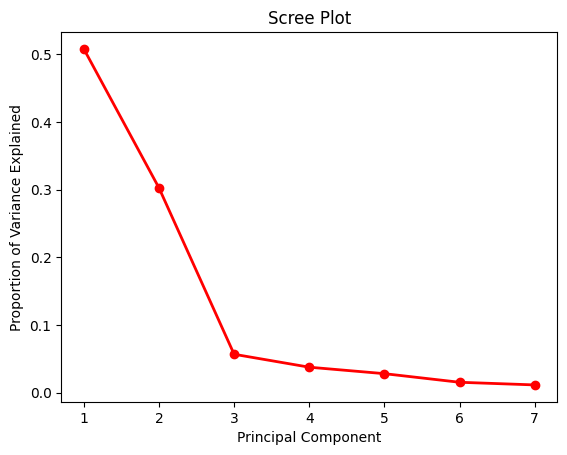

In [25]:
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')

plt.show()

In [26]:
# getting the eigenvectors into a dataframe
eigenvectors_df = pd.DataFrame(
    data=pca.components_.T,
    columns=[f"P{i}" for i in range(1, pca.n_components_ + 1)],
    index=X_num.columns
)

# print eigenvalue for each principal component
print(pca.explained_variance_)

# print cumulative sum of explained variance ratio (we will extract until 0.8)
print(np.cumsum(pca.explained_variance_ratio_))

# print eigenvectors
eigenvectors_df.head()

[91.93159228 54.75029329 10.23748244  6.77779152  5.04685169  2.74543499
  2.03584239]
[0.50776262 0.81016305 0.86670738 0.90414293 0.93201803 0.9471818
 0.9584263 ]


,P1,P2,P3,P4,P5,P6,P7
Open,0.004277,0.005294,-0.055439,0.038034,-0.084423,0.239612,0.016630
High,0.004169,0.005229,-0.054945,0.037908,-0.083380,0.239003,0.015631
Low,0.004403,0.005366,-0.056192,0.038347,-0.085786,0.241184,0.017683
Volume,-0.007662,0.039974,0.921455,-0.092100,0.032186,0.179620,0.015032
Dividends,0.000078,-0.000370,-0.001122,0.000212,-0.001285,0.002738,0.001942


In [27]:
# number of components and index when cumsum reaches 0.8
n_pcs= pca.components_.shape[0]
threshold_index = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0] + 1

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(threshold_index)]

# get feature names that influence the principal components the most
most_important_names = [X.columns[most_important[i]] for i in range(threshold_index)]

for i in range(threshold_index):
  print('PC{}: {}'.format(i + 1, most_important_names[i]))

PC1: PayablesAndAccruedExpenses
PC2: StockholdersEquity
PC3: Open
PC4: SP500Index
PC5: CoreCPI
PC6: NetIncome
PC7: TaxProvision


# Creating final training dataset

In [28]:
# combine variables and principal components
df_final = pd.concat([
    X[['Date', 'Ticker', 'Sector']],
    pd.DataFrame(
        X_pca,
        columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)]
    ),
    y
], axis=1)

# verify shapes of X and y are compatible
print(df_final.shape, y.shape)

(28654, 11) (28621,)


In [29]:
df_final.head()

,Date,Ticker,Sector,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Close_diff
1,2021-01-05,AMC,Communication Services,-5.516603,-1.823569,-0.896245,0.556528,6.709523,-1.639244,-1.538939,-0.179698
2,2021-01-06,AMC,Communication Services,-5.515781,-1.829715,-1.040180,0.549296,6.686537,-1.669019,-1.548698,0.135102
3,2021-01-07,AMC,Communication Services,-5.516209,-1.827658,-0.994712,0.540305,6.685702,-1.658487,-1.551410,0.187568
4,2021-01-08,AMC,Communication Services,-5.516275,-1.827188,-0.987187,0.536489,6.673105,-1.653089,-1.544475,0.449900
5,2021-01-11,AMC,Communication Services,-5.516125,-1.827163,-0.988748,0.541672,6.678904,-1.649374,-1.545684,0.292501


# ARIMA Model

In [49]:
def prep_SARIMAX_data(ticker):
  ticker_df = df_final[df_final['Ticker'] == ticker] \
    .drop(columns=['Ticker', 'Sector'])

  ticker_df = ticker_df.set_index('Date')
  ticker_df.index = pd.to_datetime(ticker_df.index)

  ticker_df = ticker_df.asfreq('D')
  ticker_df.ffill(inplace=True)

  train_split = 0.8

  train_df = ticker_df[:int(len(ticker_df) * train_split)]
  test_df = ticker_df[int(len(ticker_df) * train_split):]

  X_train = train_df.drop(columns=['Close_diff'])
  y_train = train_df['Close_diff']

  X_test = test_df.drop(columns=['Close_diff'])
  y_test = test_df['Close_diff']

  return X_train, y_train, X_test, y_test

In [110]:
def find_best_model(ticker, iter):
  # Define the hyperparameter grid
  param_grid = {
      'order': [(p, d, q) for p in range(5) for d in range(2) for q in range(5)],
      'seasonal_order': [(P, D, Q, S) for P in range(2) for D in range(2) for Q in range(2) for S in [5]],
  }

  # Grid search over the parameter space
  grid = list(ParameterGrid(param_grid))

  # Generate random samples of hyperparameters
  random_samples = random.sample(list(ParameterGrid(param_grid)), iter)

  X_train, y_train, X_test, y_test = prep_SARIMAX_data('AAPL')

  best_aic = np.inf
  best_order = None
  best_seasonal_order = None
  best_model = None

  for params in random_samples:
      order = params['order']
      seasonal_order = params['seasonal_order']

      try:
          # Fit the SARIMAX model
          model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
          model_fitted = model.fit(disp=False)

          # Check AIC of the fitted model
          aic = model_fitted.aic

          # If the model has the lowest AIC so far, store the parameters and model
          if aic < best_aic:
              best_aic = aic
              best_order = order
              best_seasonal_order = seasonal_order
              best_model = model_fitted

          print(f"Order: {order}, Seasonal Order: {seasonal_order}, AIC: {aic}")

      except Exception as e:
          print(f"Skipping order {order} and seasonal order {seasonal_order} due to error: {e}")

  print(f"Best Order: {best_order}, Best Seasonal Order: {best_seasonal_order}, Best AIC: {best_aic}")
  return best_model

In [112]:
def train_and_evaluate_models(ticker, iter):
  # create dictionary for tracking best model for each ticker
  results_dict = {}
  results_dict['Ticker'] = ticker

  # find best model
  X_train, y_train, X_test, y_test = prep_SARIMAX_data(ticker)
  best_model = find_best_model(ticker, iter)

  results_dict['Order'] = best_model.model.order
  results_dict['Seasonal Order'] = best_model.model.seasonal_order

  # get test data predictions
  forecast = best_model.get_forecast(steps=len(y_test), exog=X_test)
  y_pred = forecast.predicted_mean
  y_train_pred = best_model.predict(start=0, end=len(y_train) - 1, exog=X_train)

  # Calculate MAE, MSE, RMSE, and R-squared
  results_dict['Train MAE'] = mean_absolute_error(y_train, y_train_pred)
  results_dict['Train MSE'] = mean_squared_error(y_train, y_train_pred)
  results_dict['Train R2'] = r2_score(y_train, y_train_pred)

  results_dict['Test MAE'] = mean_absolute_error(y_test, y_pred)
  results_dict['Test MSE'] = mean_squared_error(y_test, y_pred)
  results_dict['Test R2'] = r2_score(y_test, y_pred)

  # x axis offset logic
  offset = len(y_train)
  x_bounds_train = range(offset)
  x_bounds_test = range(offset, offset + len(y_test))

  # initialize plot
  plt.figure(figsize=(12, 6))

  # plot training and testing actual vs. predictions
  plt.plot(x_bounds_train, y_train, label='Actual Close Stock Price (Train)')
  plt.plot(x_bounds_train, y_train_pred, label='Predicted Close Stock Price (Train)')
  plt.plot(x_bounds_test, y_test, label='Actual Close Stock Price (Test)')
  plt.plot(x_bounds_test, y_pred, label='Predicted Close Stock Price (Test)')

  # create line to separate train and test predicions
  plt.axvline(x = offset, color = 'black')

  # titles
  plt.title(f'Actual vs Predicted {ticker} Stock Price Differences Using the SARIMAX Algorithm')
  plt.xlabel('Date')
  plt.ylabel('Close Price')
  plt.legend()

  # show plot
  plt.show()

  return results_dict

In [114]:
metrics_data = []

try:
  for ticker in df_final['Ticker'].unique():
    metrics_data.append(train_and_evaluate_models(ticker, 50))
except Exception as e:
  print(e)

pd.DataFrame(metrics_data)

Output hidden; open in https://colab.research.google.com to view.

In [115]:
pd.DataFrame(metrics_data).to_csv('/content/gdrive/MyDrive/ISAN Project/Datasets/SARIMAX_model_metrics.csv', index=False)